In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
# For XGBoost
from xgboost import XGBRegressor

# For LightGBM
from lightgbm import LGBMRegressor

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats
import warnings
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import TimeSeriesSplit, learning_curve,GridSearchCV
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
import itertools
import warnings
warnings.filterwarnings('ignore')


In [2]:
output_dir = r"C:\Users\acksh\OneDrive\Desktop\MSAI\Machine Learning\Final_project\data\databycountry"
csv_file = os.path.join(output_dir,f'Afghanistan.csv')

columns_to_use = ['year',
    'gdp',
'temperature_change_from_ch4',
'temperature_change_from_co2',
'PC_coal_1',
'PC_coal_2',
'PC_oil_1',
 'PC_oil_2',
'PC_cement_1',
'PC_cement_2',
'PC_gas_1',
'PC_gas_2',
 
'PC_landuse_2',
'PC_flaring_1',
'PC_flaring_2',
'PC_growth_1',
'PC_growth_2',
'PC_energy_1',

'PC_ghg_2',
'PC_methane_1',
'primary_energy_consumption',
'co2_per_capita',
'co2_per_gdp',
'co2_per_unit_energy',

'share_global_co2',

'co2']

df = pd.read_csv(csv_file)

df_final= df[columns_to_use].copy()

print(df_final.isnull().sum())

year                            0
gdp                             2
temperature_change_from_ch4     0
temperature_change_from_co2     0
PC_coal_1                       0
PC_coal_2                       0
PC_oil_1                        0
PC_oil_2                        0
PC_cement_1                     0
PC_cement_2                     0
PC_gas_1                        0
PC_gas_2                        0
PC_landuse_2                    0
PC_flaring_1                    0
PC_flaring_2                    0
PC_growth_1                     0
PC_growth_2                     0
PC_energy_1                     0
PC_ghg_2                        0
PC_methane_1                    0
primary_energy_consumption     33
co2_per_capita                  0
co2_per_gdp                     2
co2_per_unit_energy            33
share_global_co2                0
co2                             0
dtype: int64


In [3]:
# Set year as index
df_final.set_index('year', inplace=True)

# Apply log transformation to the target variable
df_final['log_co2'] = np.log1p(df_final['co2'])

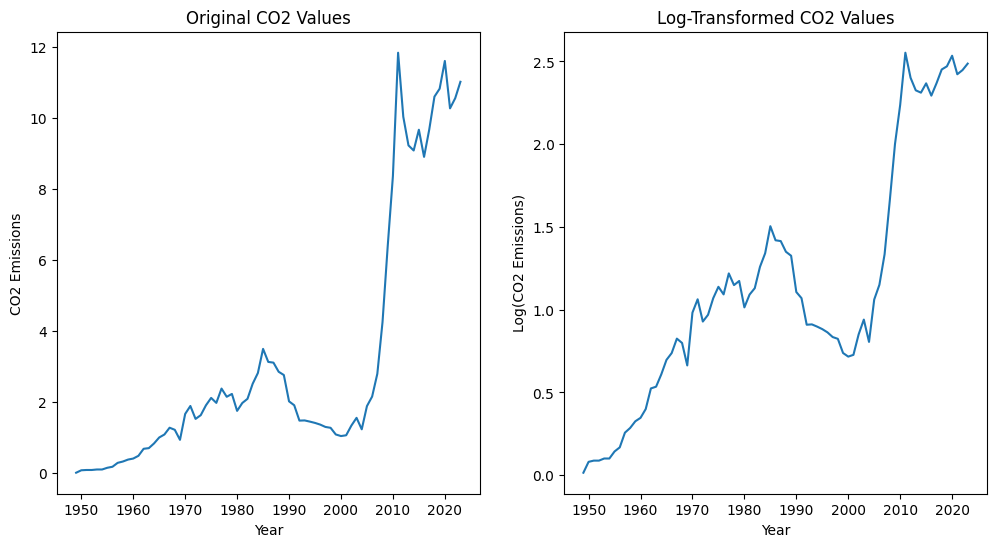

Training data shape: (60, 26)
Testing data shape: (15, 26)

Performing grid search for ARIMA parameters (keeping d=1)...
Error with ARIMA(0,1,0): name 'sqrt' is not defined
Error with ARIMA(0,1,1): name 'sqrt' is not defined
Error with ARIMA(0,1,2): name 'sqrt' is not defined
Error with ARIMA(1,1,0): name 'sqrt' is not defined
Error with ARIMA(1,1,1): name 'sqrt' is not defined
Error with ARIMA(1,1,2): name 'sqrt' is not defined
Error with ARIMA(2,1,0): name 'sqrt' is not defined
Error with ARIMA(2,1,1): name 'sqrt' is not defined
Error with ARIMA(2,1,2): name 'sqrt' is not defined

Grid search results (sorted by RMSE):
Empty DataFrame
Columns: [p, d, q, AIC, BIC, RMSE]
Index: []

Best ARIMA order based on RMSE: None

Fitting ARIMANone model on training data...


TypeError: 'NoneType' object is not subscriptable

In [6]:
# Plot the original and log-transformed CO2 values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(df_final.index, df_final['co2'])
plt.title('Original CO2 Values')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')


plt.subplot(1, 2, 2)
plt.plot(df_final.index, df_final['log_co2'])
plt.title('Log-Transformed CO2 Values')
plt.xlabel('Year')
plt.ylabel('Log(CO2 Emissions)')

plt.show()

# Split the data into training and testing sets (80% for training)
train_size = int(len(df_final) * 0.8)
train_data = df_final.iloc[:train_size]
test_data = df_final.iloc[train_size:]

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

# Function to fit ARIMA model and make predictions
def fit_arima_model(train_series, test_series, order=(1, 1, 1)):
    # Fit the ARIMA model
    model = ARIMA(train_series, order=order)
    model_fit = model.fit()
    
    # Summary of the model
    print(model_fit.summary())
    
    # Calculate residuals
    residuals = pd.Series(model_fit.resid, index=train_series.index)
    
    # Make predictions for test data
    predictions = model_fit.forecast(steps=len(test_series))
    
    # Convert predictions back to original scale
    original_scale_preds = np.expm1(predictions)
    original_scale_actual = np.expm1(test_series)
    
    # Evaluate the model
    mse = mean_squared_error(original_scale_actual, original_scale_preds)
    rmse = sqrt(mse)
    mae = mean_absolute_error(original_scale_actual, original_scale_preds)
    r2 = r2_score(original_scale_actual, original_scale_preds)
    
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R-squared: {r2:.4f}")
    
    return model_fit, predictions, original_scale_preds, original_scale_actual, residuals

# Function to plot results
def plot_results(train_series, test_series, predictions, original_scale_preds, original_scale_actual):
    # Plot log-transformed results
    plt.figure(figsize=(12, 6))
    plt.plot(train_series.index, train_series, label='Training Data')
    plt.plot(test_series.index, test_series, label='Actual Test Data')
    plt.plot(test_series.index, predictions, label='Predicted Test Data')
    plt.title('ARIMA Model: Log-Transformed CO2 Predictions vs Actual')
    plt.xlabel('Year')
    plt.ylabel('Log(CO2 Emissions)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot original scale results
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, np.expm1(train_series), label='Training Data')
    plt.plot(test_series.index, original_scale_actual, label='Actual Test Data')
    plt.plot(test_series.index, original_scale_preds, label='Predicted Test Data')
    plt.title('ARIMA Model: CO2 Predictions vs Actual (Original Scale)')
    plt.xlabel('Year')
    plt.ylabel('CO2 Emissions')
    plt.legend()
    plt.grid(True)
    plt.show()

# Perform a grid search to find the best ARIMA parameters
# Define the p and q parameters to test (keeping d=1)
p_values = range(0, 3)
q_values = range(0, 3)

# Create a DataFrame to store results
grid_results = pd.DataFrame(columns=['p', 'd', 'q', 'AIC', 'BIC', 'RMSE'])

# Perform the grid search
print("\nPerforming grid search for ARIMA parameters (keeping d=1)...")
best_rmse = float('inf')
best_order = None

for p, q in itertools.product(p_values, q_values):
    try:
        # Define the order
        order = (p, 1, q)
        
        # Fit the model
        model = ARIMA(train_data['log_co2'], order=order)
        model_fit = model.fit()
        
        # Make predictions
        predictions = model_fit.forecast(steps=len(test_data))
        
        # Convert to original scale
        original_scale_preds = np.expm1(predictions)
        original_scale_actual = np.expm1(test_data['log_co2'])
        
        # Calculate RMSE
        mse = mean_squared_error(original_scale_actual, original_scale_preds)
        rmse = sqrt(mse)
        
        # Store the results
        grid_results = pd.concat([grid_results, pd.DataFrame({
            'p': [p],
            'd': [1],
            'q': [q],
            'AIC': [model_fit.aic],
            'BIC': [model_fit.bic],
            'RMSE': [rmse]
        })], ignore_index=True)
        
        print(f"ARIMA({p},1,{q}) - AIC: {model_fit.aic:.4f}, BIC: {model_fit.bic:.4f}, RMSE: {rmse:.4f}")
        
        # Update the best model if this one is better
        if rmse < best_rmse:
            best_rmse = rmse
            best_order = order
            
    except Exception as e:
        print(f"Error with ARIMA({p},1,{q}): {str(e)}")
        continue

# Sort the results by RMSE
grid_results = grid_results.sort_values('RMSE')
print("\nGrid search results (sorted by RMSE):")
print(grid_results)

print(f"\nBest ARIMA order based on RMSE: {best_order}")

# Fit the best model
print(f"\nFitting ARIMA{best_order} model on training data...")
model_fit, predictions, original_scale_preds, original_scale_actual, residuals = fit_arima_model(
    train_data['log_co2'], 
    test_data['log_co2'],
    order=best_order
)

# Plot the results
plot_results(train_data['log_co2'], test_data['log_co2'], predictions, original_scale_preds, original_scale_actual)

# Plot the residuals - only ACF and PACF for the best model
plt.figure(figsize=(12, 6))

# ACF of residuals
plt.subplot(1, 2, 1)
plot_acf(residuals, lags=20, title='ACF of Residuals', zero=False)
plt.grid(True)

# PACF of residuals
plt.subplot(1, 2, 2)
plot_pacf(residuals, lags=20, title='PACF of Residuals', zero=False)
plt.grid(True)

plt.tight_layout()
plt.show()

# Make forecast for the next 10 years
last_year = df_final.index.max()
forecast_years = list(range(last_year + 1, last_year + 11))

# Fit the model on the entire dataset using the best parameters from grid search
full_model = ARIMA(df_final['log_co2'], order=best_order)
full_model_fit = full_model.fit()

# Plot residuals for the full model - only ACF and PACF
# Just use the final model directly, don't create redundant plots
# We already have the ACF/PACF plots for the best model above

# Generate forecasts in log-transformed scale
forecast = full_model_fit.forecast(steps=10)

# Convert forecasts back to original scale
forecast_original = np.expm1(forecast)

# Create a DataFrame for forecasts
forecast_df = pd.DataFrame({
    'year': forecast_years,
    'forecast_log_co2': forecast,
    'forecast_co2': forecast_original
})
forecast_df.set_index('year', inplace=True)

# Calculate percentage change from previous year
forecast_df['pct_change'] = forecast_df['forecast_co2'].pct_change() * 100
# Calculate percentage change from the last historical year
last_historical_co2 = df_final['co2'].iloc[-1]
forecast_df['pct_change_from_last_historical'] = ((forecast_df['forecast_co2'] - last_historical_co2) / last_historical_co2) * 100

print("\nForecasted CO2 emissions for the next 10 years:")
print(forecast_df[['forecast_co2', 'pct_change', 'pct_change_from_last_historical']])

# Plot the historical data and forecast
plt.figure(figsize=(14, 7))
plt.plot(df_final.index, df_final['co2'], label='Historical CO2 Emissions')
plt.plot(forecast_df.index, forecast_df['forecast_co2'], label='Forecasted CO2 Emissions', color='red')

# Add a vertical line to separate historical data from forecast
plt.axvline(x=last_year, color='black', linestyle='--', alpha=0.7)
plt.text(last_year - 2, df_final['co2'].max() * 0.9, 'Historical', ha='right')
plt.text(last_year + 2, df_final['co2'].max() * 0.9, 'Forecast', ha='left')

plt.title('Historical and Forecasted CO2 Emissions (10-Year Forecast)')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Create a DataFrame with confidence intervals for the forecast
conf_int = full_model_fit.get_forecast(steps=10).conf_int()
conf_int_original = np.expm1(conf_int)
forecast_df['lower_ci'] = conf_int_original.iloc[:, 0]
forecast_df['upper_ci'] = conf_int_original.iloc[:, 1]

# Plot with confidence intervals
plt.figure(figsize=(14, 7))
plt.plot(df_final.index, df_final['co2'], label='Historical CO2 Emissions')
plt.plot(forecast_df.index, forecast_df['forecast_co2'], label='Forecasted CO2 Emissions', color='red')

# Add confidence intervals
plt.fill_between(forecast_df.index, 
                 forecast_df['lower_ci'], 
                 forecast_df['upper_ci'], 
                 color='pink', alpha=0.3, 
                 label='95% Confidence Interval')

# Add a vertical line to separate historical data from forecast
plt.axvline(x=last_year, color='black', linestyle='--', alpha=0.7)
plt.text(last_year - 2, df_final['co2'].max() * 0.9, 'Historical', ha='right')
plt.text(last_year + 2, df_final['co2'].max() * 0.9, 'Forecast', ha='left')

plt.title('Historical and Forecasted CO2 Emissions with Confidence Intervals')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# Save the forecast to a CSV file
forecast_df.to_csv('co2_forecast_results.csv')
print("Forecast results saved to 'co2_forecast_results.csv'")

# Print a summary of forecasted percentage changes
print("\nSummary of Forecasted CO2 Emission Changes:")
print(f"Average annual percentage change: {forecast_df['pct_change'].mean():.2f}%")
print(f"Total percentage change over forecast period: {forecast_df['pct_change_from_last_historical'].iloc[-1]:.2f}%")
print(f"Minimum annual percentage change: {forecast_df['pct_change'].min():.2f}%")
print(f"Maximum annual percentage change: {forecast_df['pct_change'].max():.2f}%")